In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns

from tensorflow.keras import datasets, layers, models
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten , BatchNormalization , Activation , Dropout

import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
TARGET_X = 128
TARGET_Y = 128
BATCH_SIZE = 64
CLASS_NUM = 34
EPOCH = 10

In [3]:
def append_ext(fn):
    return fn+".png"

def f2_score(tp,fp,fn):
    p = tp/(tp+fp)
    r = tp/(tp + fn)
    
    return ((1 + B^2)*p*r)/(B^2*p+r)

def f2_score(y_true, y_pred):
    B = 2
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=1)
    pred_p = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=1)
    poss_p = K.sum(K.round(K.clip(y_true, 0, 1)), axis=1)
    
    p = tp / (pred_p + K.epsilon())
    r = tp / (poss_p + K.epsilon())
    
    return K.mean(((1+B**2)*p*r) / ((B**2)*p+r+K.epsilon()))

gamma = 2.0
epsilon = K.epsilon()
def focal_loss(y_true, y_pred):
    pt = y_pred * y_true + (1-y_pred) * (1-y_true)
    pt = K.clip(pt, epsilon, 1-epsilon)
    CE = -K.log(pt)
    FL = K.pow(1-pt, gamma) * CE
    loss = K.sum(FL, axis=1)
    return loss

train_classes=pd.read_csv('/Users/gustavonrm/Desktop/VCOM/proj2/multilabel.csv', dtype=str)
#Changing the attribute ids into lists instead of str seperated by a ' ' to be able to count them
train_classes['attribute_ids']=train_classes['attribute_ids'].str.split(' ')
train_classes["id"]=train_classes["id"].apply(append_ext)


print('train : \n', train_classes.head())

train : 
                      id attribute_ids
0  1000483014d91860.png         [147]
1  1000fe2e667721fe.png          [51]
2  10041eb49b297c08.png          [51]
3  100501c227f8beea.png          [13]
4  10050ed12fbad46d.png         [189]


In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

train_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="training",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

valid_gen = datagen.flow_from_dataframe(dataframe= train_classes,
                                             directory='/Users/gustavonrm/Desktop/VCOM/proj2/data',
                                             x_col="id",
                                             y_col="attribute_ids",
                                             subset="validation",
                                             target_size = (TARGET_X,TARGET_Y),
                                             batch_size=BATCH_SIZE,
                                             class_name='categorical')

/usr/local/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 71944 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
Found 17330 validated image filenames belonging to 34 classes.
Found 4332 validated image filenames belonging to 34 classes.
/usr/local/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 71944 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [5]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same', input_shape=(TARGET_X, TARGET_Y, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(5,5),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2048))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(CLASS_NUM, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0

In [6]:
from keras import optimizers

optimizer = optimizers.Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[f2_score])
# model.compile(optimizer=optimizer, loss="binary_crossentropy",metrics=["accuracy", "categorical_accuracy"])

STEP_SIZE_TRAIN = train_gen.n//train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n//valid_gen.batch_size

history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    verbose=1)

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/10
270/270 [==============================] - 1370s 5s/step - loss: 3.0452 - f2_score: 0.3745 - val_loss: 3.8584 - val_f2_score: 0.2369
Epoch 2/10
270/270 [==============================] - 1225s 5s/step - loss: 2.2268 - f2_score: 0.4651 - val_loss: 3.1309 - val_f2_score: 0.2331
Epoch 3/10
270/270 [==============================] - 1218s 5s/step - loss: 2.3158 - f2_score: 0.4574 - val_loss: 2.9514 - val_f2_score: 0.2346
Epoch 4/10
270/270 [==============================] - 1256s 5s/step - loss: 2.4901 - f2_score: 0.4451 - val_loss: 3.6303 - val_f2_score: 0.2027
Epoch 5/10
270/270 [==============================] - 1203s 4s/step - loss: 2.6690 - f2_score: 0.4377 - val_loss: 3.0517 - val_f2_score: 0.2635
Epoch 6/10
270/270 [==============================] - 1229s 5s/step - loss: 2.7692 - f2_sco

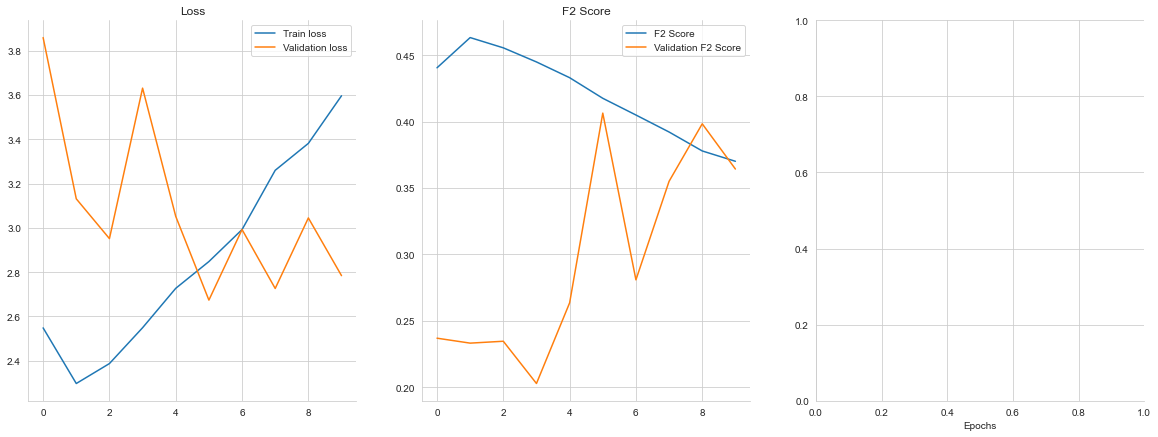

In [8]:
sns.set_style("whitegrid")
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['f2_score'], label='F2 Score')
ax2.plot(history.history['val_f2_score'], label='Validation F2 Score')
ax2.legend(loc='best')
ax2.set_title('F2 Score')

plt.xlabel('Epochs')
sns.despine()
plt.show()